## El ejemplo base ha sido tomado de:  
http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/  
Donde puede ser consultado con las explicaciones correspondientes

# Implementando una Red Neuronal desde Cero - Una Introducción

En este post implementaremos una red neuronal simple de 3 capas desde cero. No derivaremos todas las matemáticas necesarias, pero intentaré dar una explicación intuitiva de lo que estamos haciendo y señalaré recursos para profundizar en los detalles.

En este post asumo que estás familiarizado con conceptos básicos de Cálculo y Aprendizaje Automático, por ejemplo, sabes qué es clasificación y regularización. Idealmente, también conoces un poco sobre cómo funcionan técnicas de optimización como el descenso de gradiente. Pero incluso si no estás familiarizado con lo anterior, este post aún podría resultarte interesante ;)

Pero, ¿por qué implementar una Red Neuronal desde cero? Incluso si planeas usar librerías de Redes Neuronales como [PyBrain](http://pybrain.org) en el futuro, implementar una red desde cero al menos una vez es un ejercicio extremadamente valioso. Te ayuda a comprender cómo funcionan las redes neuronales, y eso es esencial para diseñar modelos efectivos.

Una cosa a tener en cuenta es que los ejemplos de código aquí no son terriblemente eficientes. Están pensados para ser fáciles de entender. En un próximo post exploraré cómo escribir una implementación eficiente de una Red Neuronal usando [Theano](http://deeplearning.net/software/theano/). 

In [1]:
# Importación de paquetes
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import seaborn as sns  # Añadido para graficar la matriz de confusión
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Mostrar gráficos en línea y cambiar el tamaño de figura predeterminado
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## Generando un conjunto de datos

Comencemos generando un conjunto de datos con el que podamos trabajar. Afortunadamente, [scikit-learn](http://scikit-learn.org/) tiene algunos generadores de conjuntos de datos útiles, por lo que no necesitamos escribir el código nosotros mismos. Utilizaremos la función [`make_moons`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html).

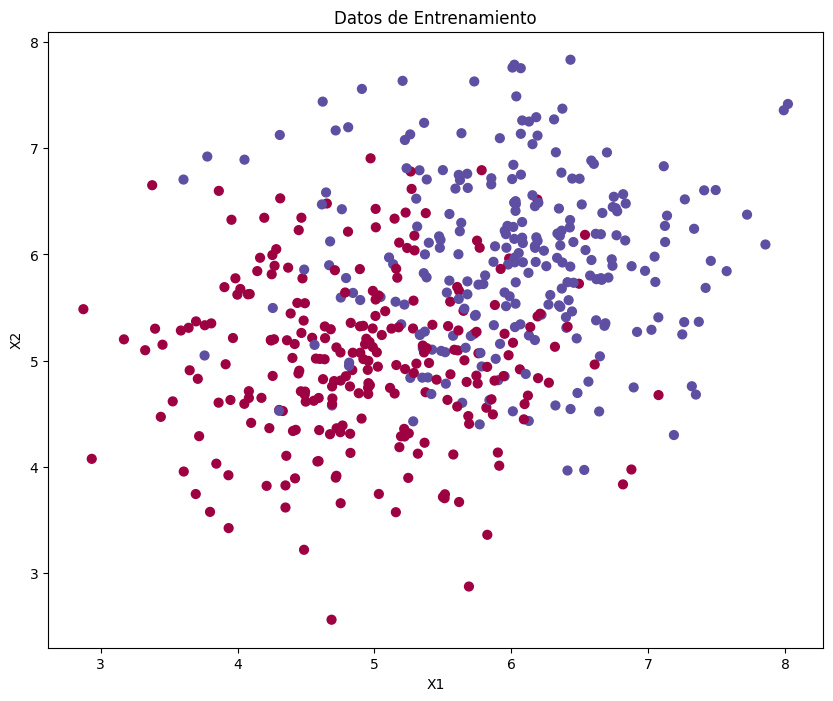

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Semilla para reproducibilidad
np.random.seed(0)

# Generar las dos nubes de puntos con make_blobs
X, y = make_blobs(n_samples=1000, centers=[[5, 5], [6, 6]], cluster_std=0.8, random_state=0)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Graficar los datos de entrenamiento
plt.scatter(X_train[:, 0], X_train[:, 1], s=40, c=y_train, cmap=plt.cm.Spectral)
plt.title('Datos de Entrenamiento')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()


El conjunto de datos que generamos tiene dos clases, representadas como puntos rojos y azules. Puedes pensar en los puntos azules como pacientes masculinos y los puntos rojos como pacientes femeninos, con los ejes x e y siendo medidas médicas.

Nuestro objetivo es entrenar un clasificador de Aprendizaje Automático que prediga la clase correcta (masculino o femenino) dadas las coordenadas x e y. Ten en cuenta que los datos no son *linealmente separables*, no podemos dibujar una línea recta que separe las dos clases. Esto significa que los clasificadores lineales, como la Regresión Logística, no podrán ajustar los datos a menos que ingenies características no lineales (como polinomios) que funcionen bien para el conjunto de datos dado.

De hecho, esa es una de las principales ventajas de las Redes Neuronales. No necesitas preocuparte por la [ingeniería de características](http://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/). La capa oculta de una red neuronal aprenderá características por ti.

In [3]:
# Función auxiliar para graficar una frontera de decisión
def plot_decision_boundary(pred_func, X, y):
    # Establecer valores mínimos y máximos y darle algo de relleno
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generar una cuadrícula de puntos con distancia h entre ellos
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predecir el valor de la función para toda la cuadrícula
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Graficar el contorno y los ejemplos
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

## Entrenando una Red Neuronal

Ahora construiremos una red neuronal de 3 capas con una capa de entrada, una capa oculta y una capa de salida. El número de nodos en la capa de entrada está determinado por la dimensionalidad de nuestros datos, 2. De manera similar, el número de nodos en la capa de salida está determinado por el número de clases que tenemos, también 2. (Debido a que solo tenemos 2 clases, podríamos arreglárnoslas con solo un nodo de salida prediciendo 0 o 1, pero tener 2 hace que sea más fácil extender la red a más clases más adelante). La entrada a la red serán las coordenadas x e y y su salida serán dos probabilidades, una para la clase 0 ("femenino") y otra para la clase 1 ("masculino"). Se ve algo así:

<img src='./nn-3-layer-network.png' style='width: 50%'/>

Podemos elegir la dimensionalidad (el número de nodos) de la capa oculta. Cuantos más nodos pongamos en la capa oculta, más funciones complejas podremos ajustar. Pero una mayor dimensionalidad tiene un costo. Primero, se requiere más computación para hacer predicciones y aprender los parámetros de la red. Un mayor número de parámetros también significa que somos más propensos a sobreajustar nuestros datos.

¿Cómo elegir el tamaño de la capa oculta? Aunque hay algunas pautas y recomendaciones generales, siempre depende de tu problema específico y es más un arte que una ciencia. Jugaremos con el número de nodos en la capa oculta más adelante y veremos cómo afecta nuestro resultado.

También necesitamos elegir una *función de activación* para nuestra capa oculta. La función de activación transforma las entradas de la capa en sus salidas. Una función de activación no lineal es lo que nos permite ajustar hipótesis no lineales. Las opciones comunes para las funciones de activación son [tanh](https://reference.wolfram.com/language/ref/Tanh.html), la [función sigmoide](https://es.wikipedia.org/wiki/Funci%C3%B3n_sigmoide) o [ReLUs](https://es.wikipedia.org/wiki/Unidad_lineal_rectificada). Usaremos `tanh`, que funciona bastante bien en muchos escenarios. Una propiedad interesante de estas funciones es que su derivada se puede calcular usando el valor de la función original. Por ejemplo, la derivada de $\tanh x$ es $1-\tanh^2 x$. Esto es útil porque nos permite calcular $\tanh x$ una vez y reutilizar su valor más adelante para obtener la derivada.

Porque queremos que nuestra red produzca probabilidades, la función de activación para la capa de salida será la [softmax](https://es.wikipedia.org/wiki/Funci%C3%B3n_softmax), que es simplemente una forma de convertir puntuaciones en bruto a probabilidades. Si estás familiarizado con la función logística, puedes pensar en softmax como su generalización a múltiples clases.

### Cómo nuestra red hace predicciones

Nuestra red hace predicciones usando *propagación hacia adelante*, que es solo un montón de multiplicaciones de matrices y la aplicación de las funciones de activación que definimos anteriormente. Si $x$ es la entrada de 2 dimensiones a nuestra red, entonces calculamos nuestra predicción $\hat{y}$ (también de dos dimensiones) de la siguiente manera:

$$
\begin{aligned}
z_1 & = xW_1 + b_1 \\
a_1 & = \tanh(z_1) \\
z_2 & = a_1W_2 + b_2 \\
a_2 & = \hat{y} = \mathrm{softmax}(z_2)
\end{aligned}
$$

$z_i$ es la entrada de la capa $i$ y $a_i$ es la salida de la capa $i$ después de aplicar la función de activación. $W_1, b_1, W_2, b_2$ son los parámetros de nuestra red, que necesitamos aprender de nuestros datos de entrenamiento. Puedes pensar en ellos como matrices que transforman datos entre las capas de la red. Mirando las multiplicaciones de matrices anteriores, podemos determinar la dimensionalidad de estas matrices. Si usamos 500 nodos para nuestra capa oculta, entonces $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. Ahora ves por qué tenemos más parámetros si incrementamos el tamaño de la capa oculta.

### Aprendiendo los Parámetros

Aprender los parámetros para nuestra red significa encontrar parámetros ($W_1, b_1, W_2, b_2$) que minimicen el error en nuestros datos de entrenamiento. Pero, ¿cómo definimos el error? Llamamos a la función que mide nuestro error la *función de pérdida*. Una elección común con la salida softmax es la [pérdida de entropía cruzada](https://es.wikipedia.org/wiki/Entrop%C3%ADa_cruzada#Funci%C3%B3n_de_error_de_entrop%C3%ADa_cruzada_y_regresi%C3%B3n_log%C3%ADstica). Si tenemos $N$ ejemplos de entrenamiento y $C$ clases, entonces la pérdida para nuestra predicción $\hat{y}$ con respecto a las etiquetas verdaderas $y$ está dada por:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$



La fórmula parece complicada, pero todo lo que realmente hace es sumar sobre nuestros ejemplos de entrenamiento y añadir a la pérdida si predecimos la clase incorrecta. Entonces, cuanto más alejados estén $y$ (las etiquetas correctas) y $\hat{y}$ (nuestras predicciones), mayor será nuestra pérdida.

Recuerda que nuestro objetivo es encontrar los parámetros que minimicen nuestra función de pérdida. Podemos usar [descenso de gradiente](http://cs231n.github.io/optimization-1/) para encontrar su mínimo. Implementaré la versión más simple de descenso de gradiente, también llamada descenso de gradiente por lotes con una tasa de aprendizaje fija. Variaciones como SGD (descenso de gradiente estocástico) o descenso de gradiente por minibatch generalmente funcionan mejor en la práctica. Así que si eres serio, querrás usar uno de estos, e idealmente también [reducir la tasa de aprendizaje con el tiempo](http://cs231n.github.io/neural-networks-3/#anneal).

Como entrada, el descenso de gradiente necesita los gradientes (vector de derivadas) de la función de pérdida con respecto a nuestros parámetros: $\frac{\partial{L}}{\partial{W_1}}$, $\frac{\partial{L}}{\partial{b_1}}$, $\frac{\partial{L}}{\partial{W_2}}$, $\frac{\partial{L}}{\partial{b_2}}$. Para calcular estos gradientes usamos el famoso *algoritmo de retropropagación*, que es una forma de calcular eficientemente los gradientes empezando desde la salida. No entraré en detalles sobre cómo funciona la retropropagación, pero hay muchas explicaciones excelentes ([aquí](http://colah.github.io/posts/2015-08-Backprop/) o [aquí](http://cs231n.github.io/optimization-2/)) flotando por la web.

Aplicando la fórmula de retropropagación encontramos lo siguiente (confía en mí en esto):

$$
\begin{aligned}
& \delta_3 = \hat{y} - y \\
& \delta_2 = (1 - \tanh^2z_1) \circ \delta_3W_2^T \\
& \frac{\partial{L}}{\partial{W_2}} = a_1^T \delta_3  \\
& \frac{\partial{L}}{\partial{b_2}} = \delta_3\\
& \frac{\partial{L}}{\partial{W_1}} = x^T \delta_2\\
& \frac{\partial{L}}{\partial{b_1}} = \delta_2 \\
\end{aligned}
$$

### Implementación

Ahora estamos listos para nuestra implementación. Comenzamos definiendo algunas variables y parámetros útiles para el descenso de gradiente:

In [4]:
# Parámetros de la red y del descenso de gradiente
nn_input_dim = X_train.shape[1]  # Dimensionalidad de la capa de entrada
nn_output_dim = 2  # Dimensionalidad de la capa de salida

# Parámetros de descenso de gradiente
epsilon = 0.01  # Tasa de aprendizaje para el descenso de gradiente
reg_lambda = 0.01  # Fuerza de regularización

Primero implementemos la función de pérdida que definimos anteriormente. Usamos esto para evaluar qué tan bien está funcionando nuestro modelo:

In [5]:
# Función auxiliar para evaluar la pérdida total en el conjunto de datos
def calculate_loss(model, X, y):
    num_examples = len(X)
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Propagación hacia adelante para calcular nuestras predicciones
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculando la pérdida
    correct_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(correct_logprobs)
    # Agregar término de regularización a la pérdida (opcional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

También implementamos una función auxiliar para calcular la salida de la red. Realiza la propagación hacia adelante como se definió anteriormente y devuelve la clase con la mayor probabilidad.

In [6]:
# Función auxiliar para predecir probabilidades
def predict_probs(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Propagación hacia adelante
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return probs

# Función auxiliar para predecir una salida (0 o 1)
def predict(model, x):
    probs = predict_probs(model, x)
    return np.argmax(probs, axis=1)

También implementamos funciones auxiliares para graficar la curva ROC y la matriz de confusión.

In [7]:
# Función para graficar la curva ROC
def plot_roc_curve(fpr, tpr, roc_auc, dataset_type):
    plt.plot(fpr, tpr, label='Curva ROC (área = %0.2f)' % roc_auc)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([-0.05,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC (' + dataset_type + ')')
    plt.legend(loc="lower right")

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, dataset_type):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión (' + dataset_type + ')')
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')

Finalmente, aquí viene la función para entrenar nuestra Red Neuronal. Implementa descenso de gradiente por lotes usando las derivadas de retropropagación que encontramos anteriormente.

In [8]:
# Función del modelo de Red Neuronal
def build_model(X, y, nn_hdim, num_passes=20000, print_loss=False):
    num_examples = len(X)
    nn_input_dim = X.shape[1]
    nn_output_dim = 2  # Número de clases

    # Parámetros de descenso de gradiente
    epsilon = 0.01  # Tasa de aprendizaje
    reg_lambda = 0.01  # Fuerza de regularización

    # Inicializar los parámetros a valores aleatorios
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # Esto es lo que devolvemos al final
    model = {}

    # Descenso de gradiente
    for i in range(0, num_passes):

        # Propagación hacia adelante
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Retropropagación
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Agregar términos de regularización
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Actualización de parámetros por descenso de gradiente
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2

        # Asignar nuevos parámetros al modelo
        model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

        # Opcionalmente imprimir la pérdida
        if print_loss and i % 1000 == 0:
            loss = calculate_loss(model, X, y)
            print(f"Pérdida después de la iteración {i}: {loss}")

    return model

### Variando el tamaño de la capa oculta

En el ejemplo anterior, elegimos un tamaño de capa oculta de 3. Ahora obtengamos una idea de cómo variar el tamaño de la capa oculta afecta el resultado.

Tamaño de la Capa Oculta 1


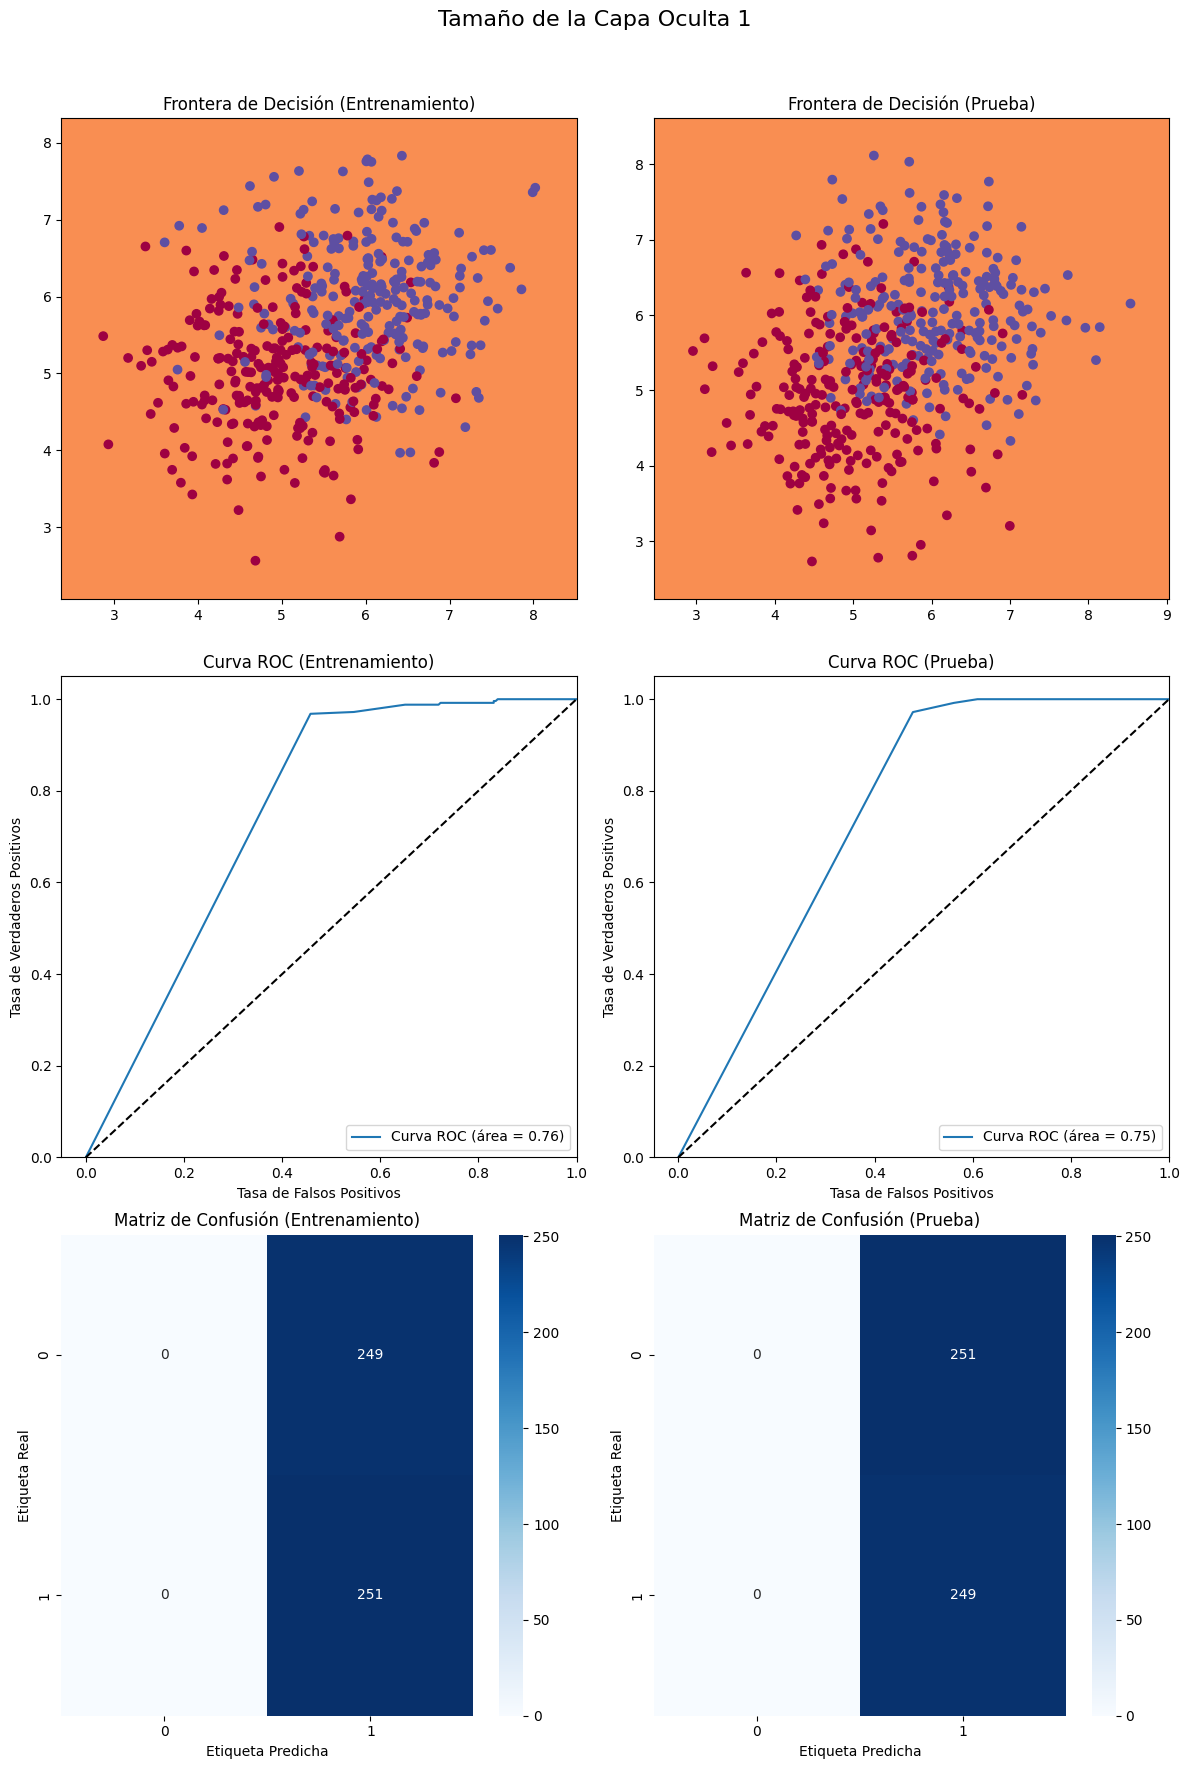

Tamaño de la Capa Oculta 3


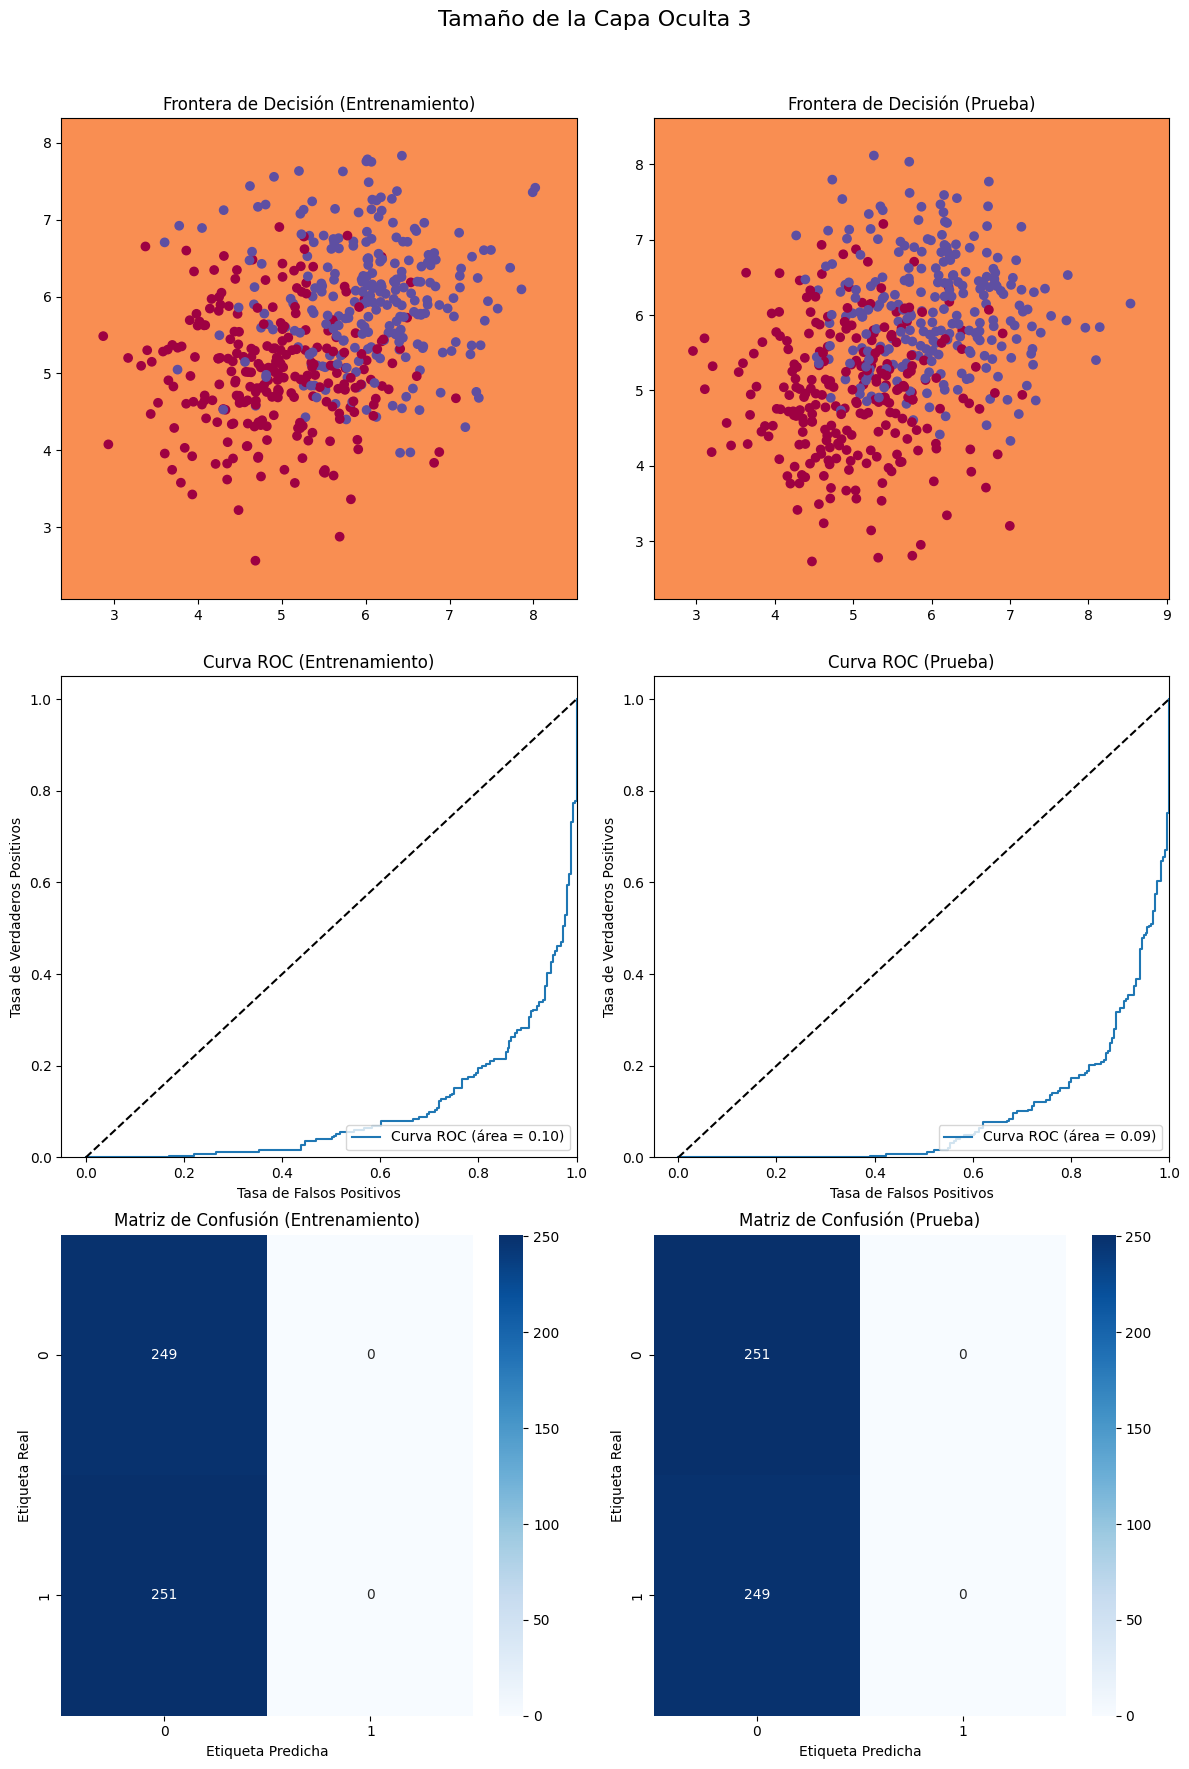

Tamaño de la Capa Oculta 5


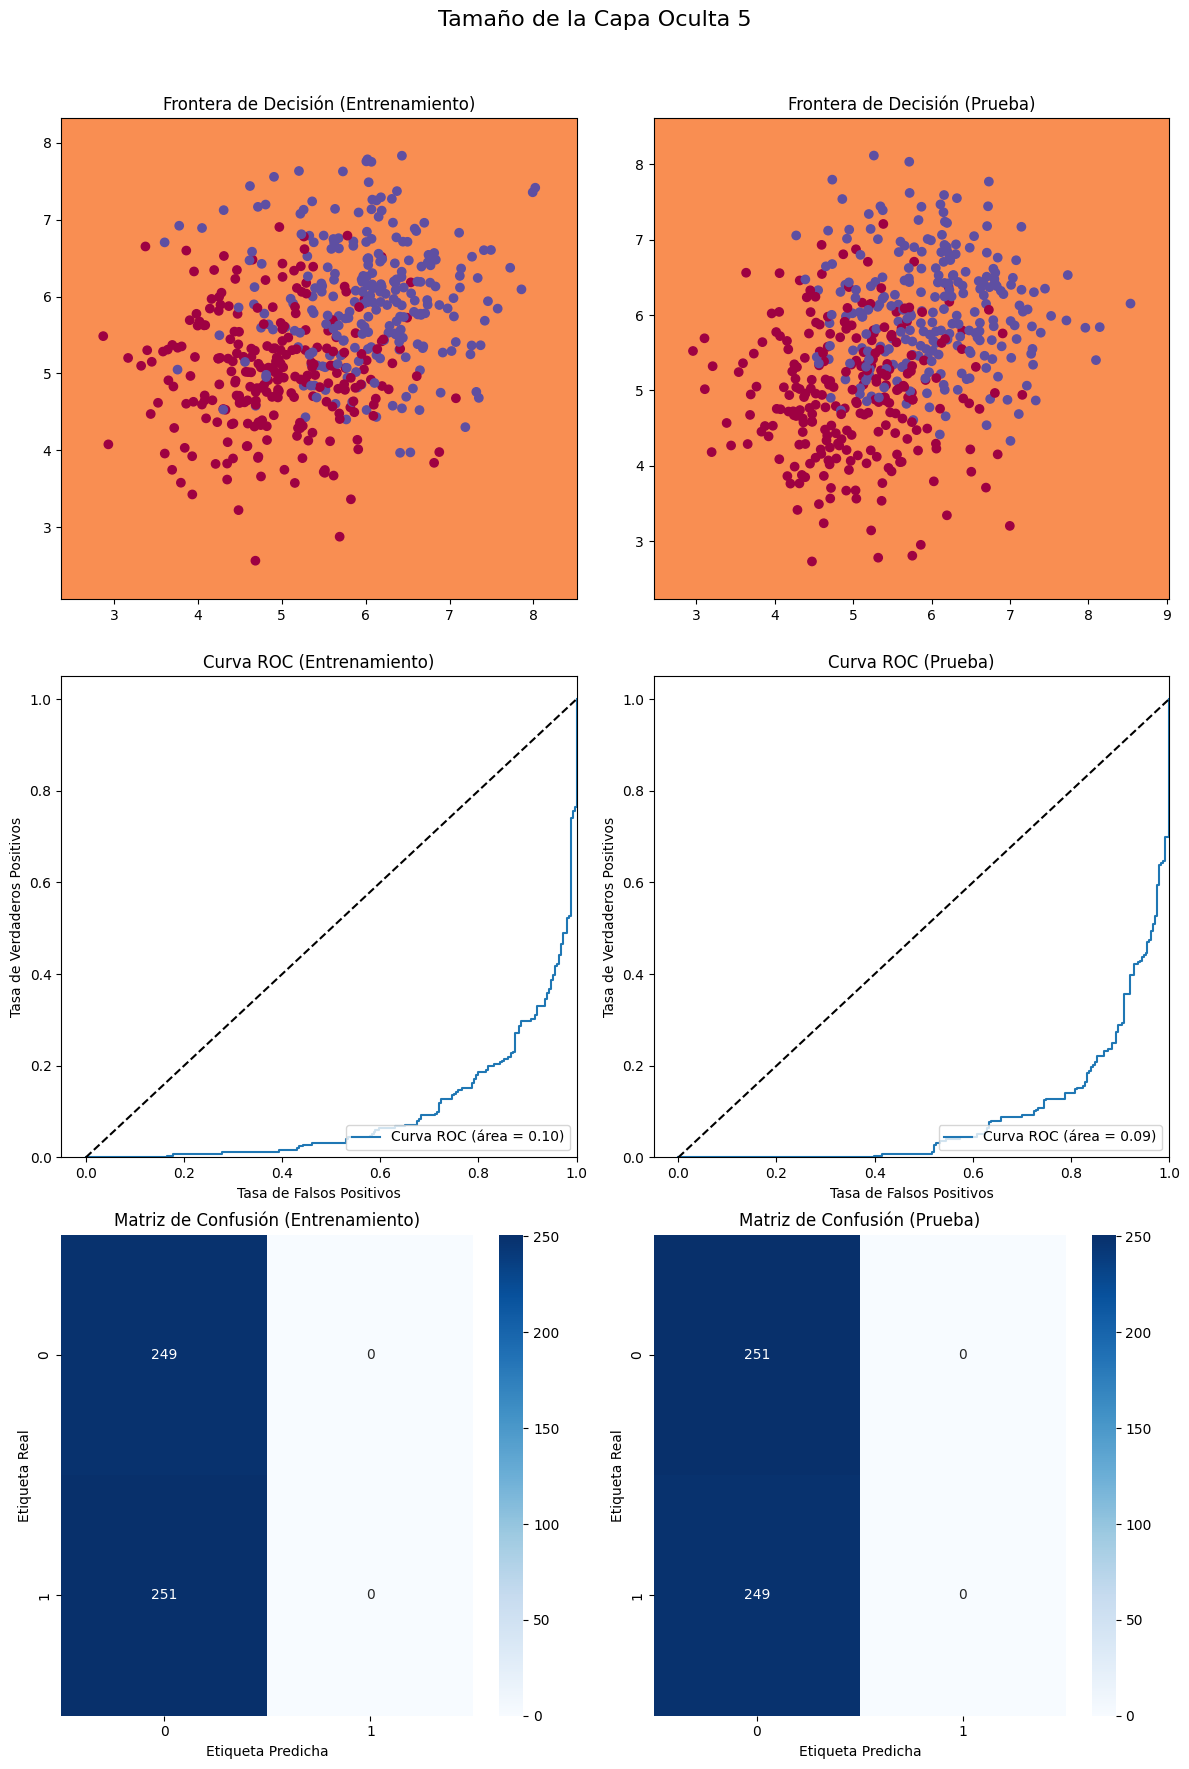

Tamaño de la Capa Oculta 20


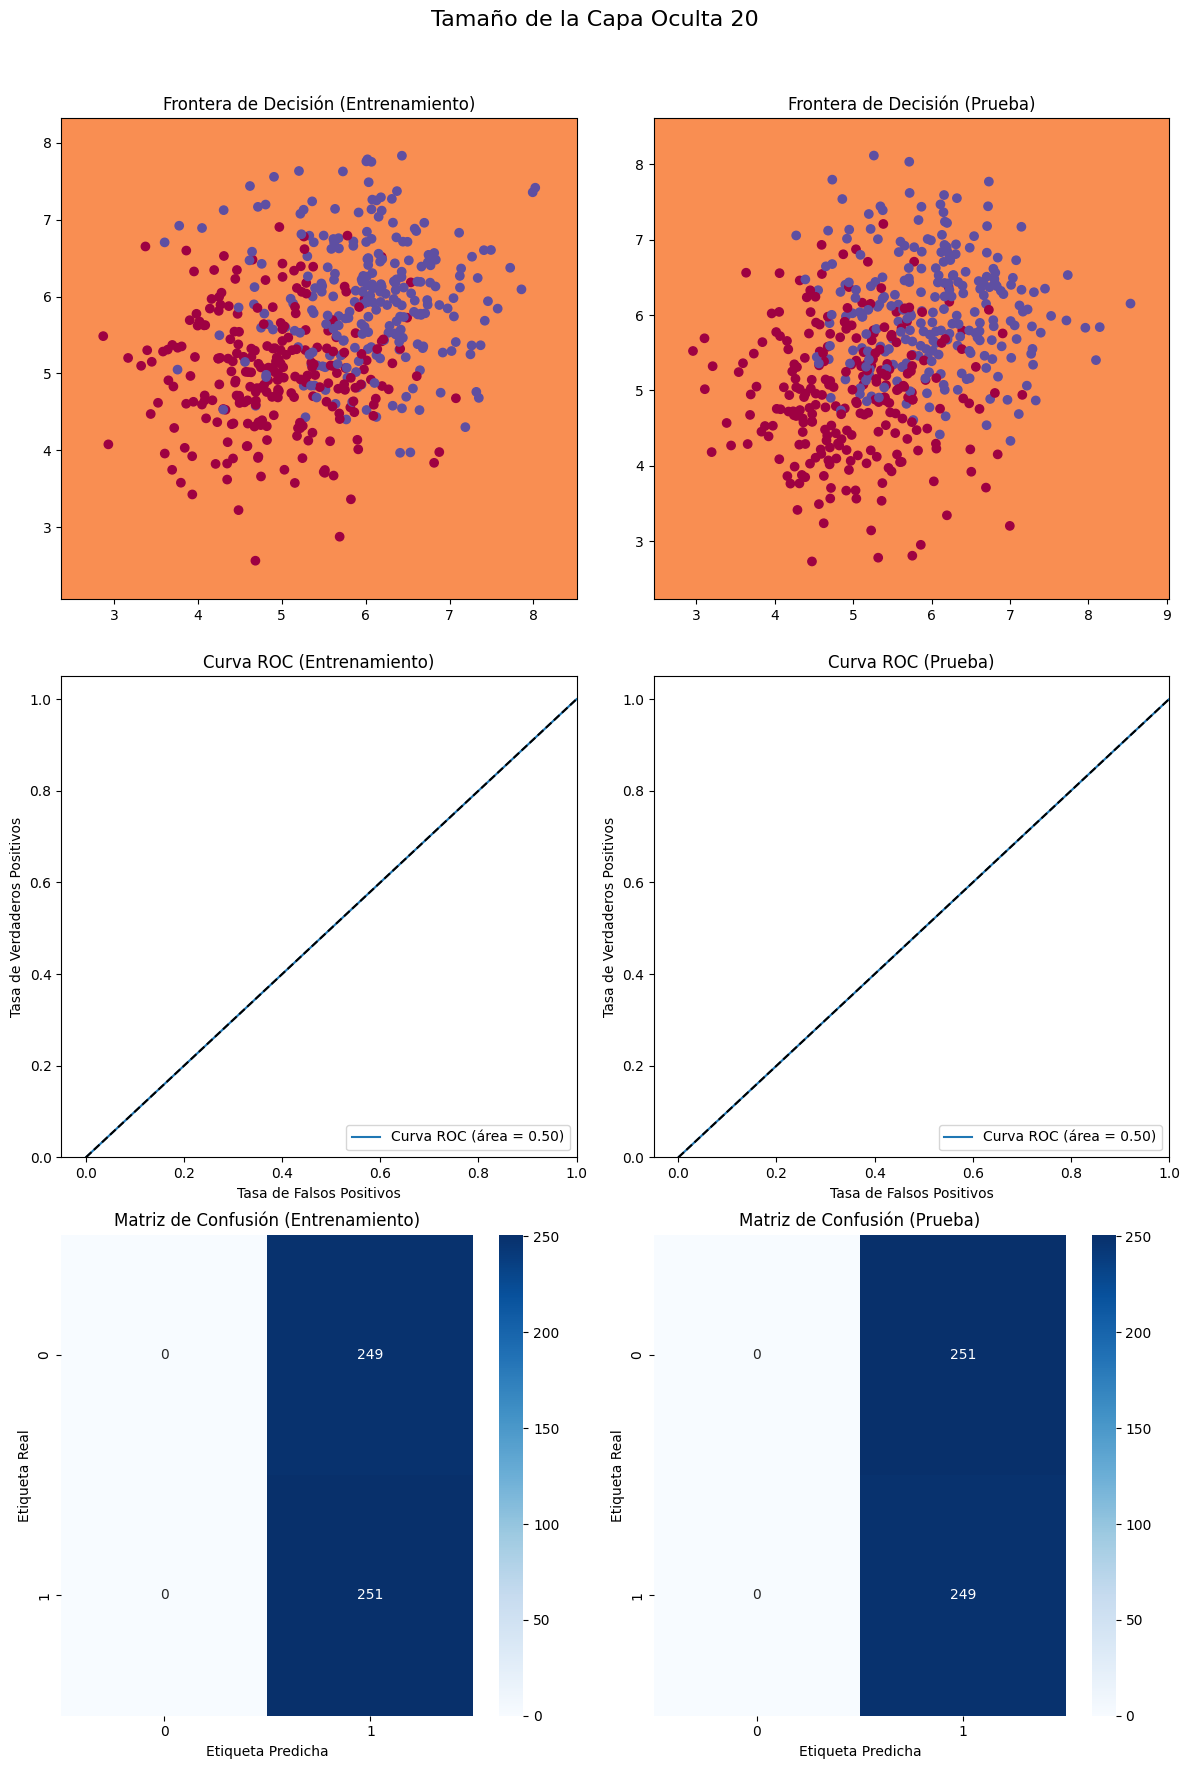

Tamaño de la Capa Oculta 50


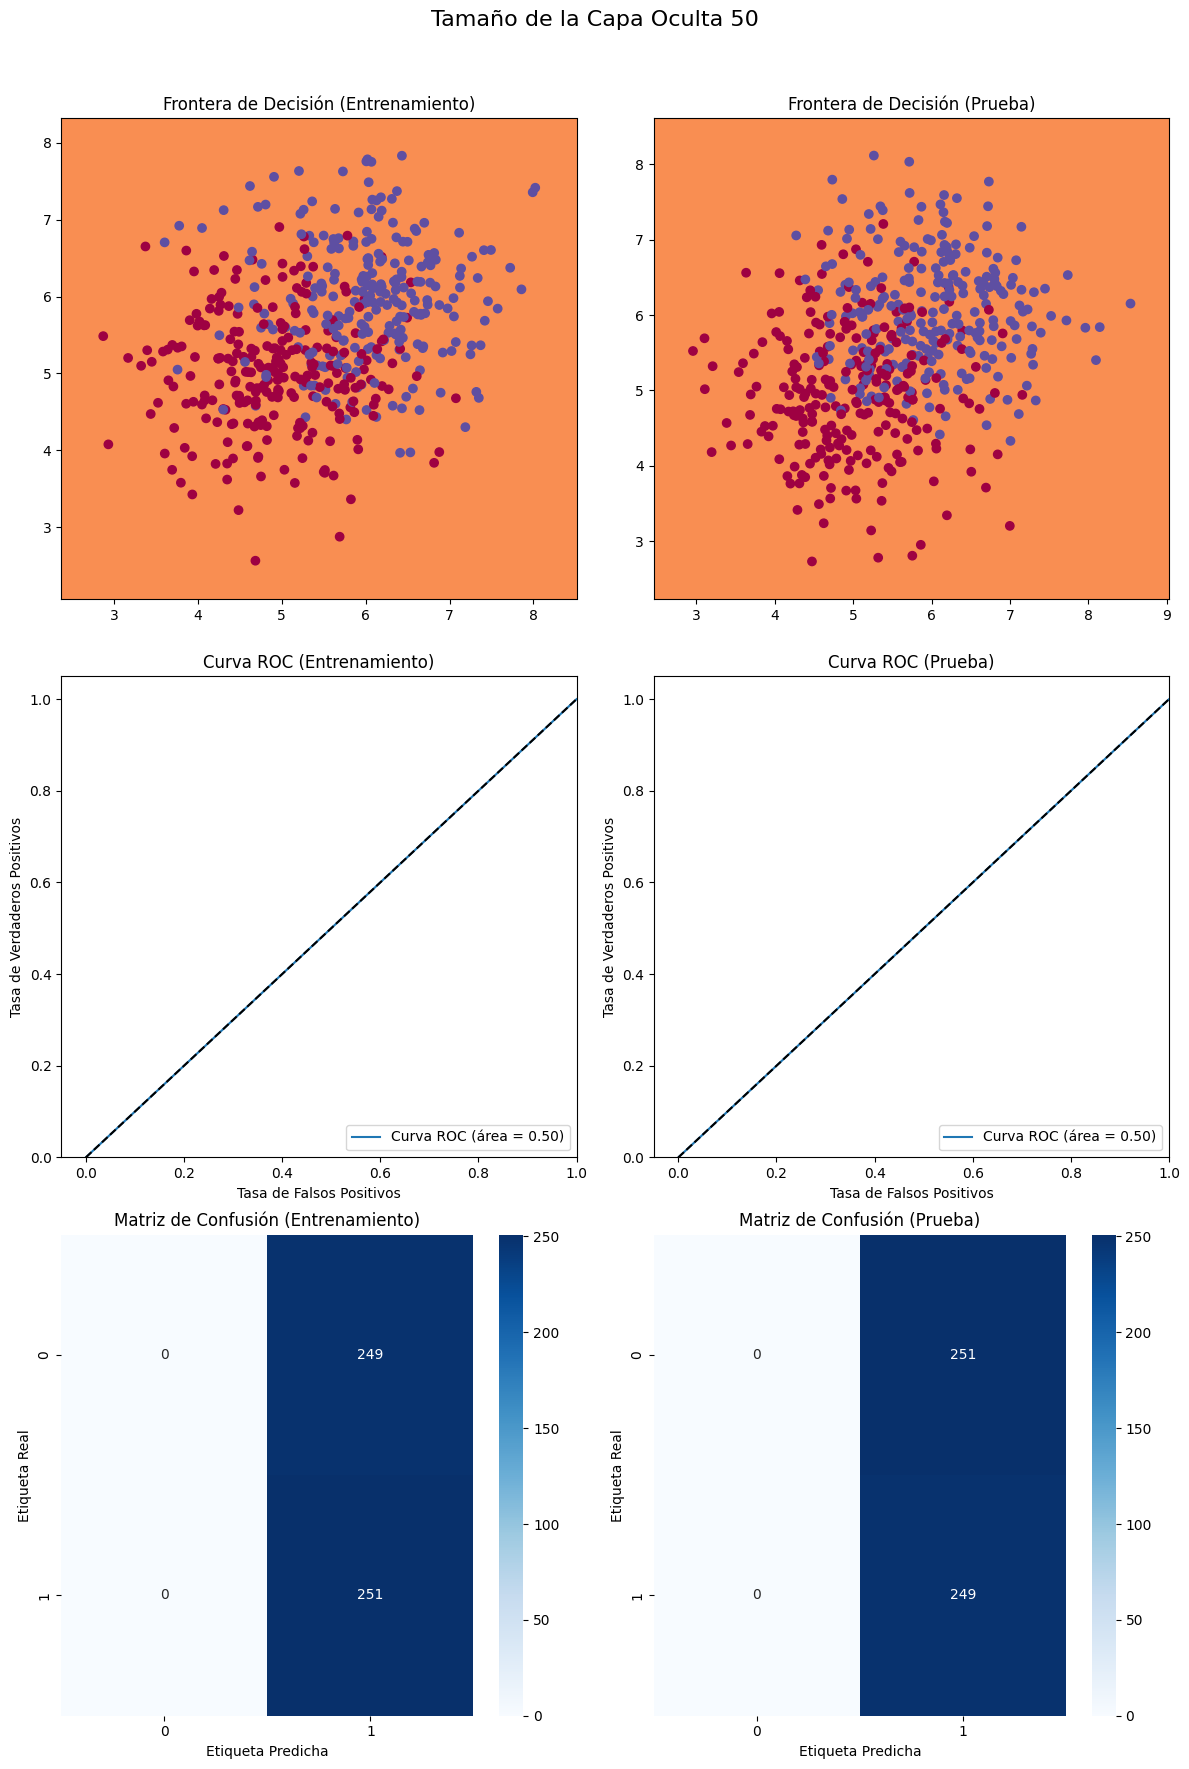

In [9]:
hidden_layer_dimensions = [1, 3, 5, 20, 50]

for nn_hdim in hidden_layer_dimensions:
    print('Tamaño de la Capa Oculta %d' % nn_hdim)
    # Entrenar el modelo
    model = build_model(X_train, y_train, nn_hdim)

    # Calcular probabilidades en los conjuntos de entrenamiento y prueba
    probs_train = predict_probs(model, X_train)
    probs_test = predict_probs(model, X_test)

    # Calcular clases predichas
    y_pred_train = np.argmax(probs_train, axis=1)
    y_pred_test = np.argmax(probs_test, axis=1)

    # Calcular curvas ROC y AUC
    fpr_train, tpr_train, _ = roc_curve(y_train, probs_train[:, 1])
    roc_auc_train = auc(fpr_train, tpr_train)

    fpr_test, tpr_test, _ = roc_curve(y_test, probs_test[:, 1])
    roc_auc_test = auc(fpr_test, tpr_test)

    # Calcular matrices de confusión
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    # Graficar
    # Crear una figura con 3 filas y 2 columnas
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))
    fig.suptitle('Tamaño de la Capa Oculta %d' % nn_hdim, fontsize=16)

    # Primera fila: Fronteras de decisión
    plt.sca(axes[0, 0])
    plot_decision_boundary(lambda x: predict(model, x), X_train, y_train)
    plt.title('Frontera de Decisión (Entrenamiento)')

    plt.sca(axes[0, 1])
    plot_decision_boundary(lambda x: predict(model, x), X_test, y_test)
    plt.title('Frontera de Decisión (Prueba)')

    # Segunda fila: Curvas ROC
    plt.sca(axes[1, 0])
    plot_roc_curve(fpr_train, tpr_train, roc_auc_train, 'Entrenamiento')

    plt.sca(axes[1, 1])
    plot_roc_curve(fpr_test, tpr_test, roc_auc_test, 'Prueba')

    # Tercera fila: Matrices de confusión
    plt.sca(axes[2, 0])
    plot_confusion_matrix(cm_train, 'Entrenamiento')

    plt.sca(axes[2, 1])
    plot_confusion_matrix(cm_test, 'Prueba')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

Podemos ver que mientras una capa oculta de baja dimensionalidad captura bien la tendencia general de nuestros datos, las dimensionalidades más altas son propensas al sobreajuste. Están "memorizando" los datos en lugar de ajustar la forma general. Si evaluáramos nuestro modelo en un conjunto de prueba separado (¡y deberías!), el modelo con un tamaño de capa oculta más pequeño probablemente rendiría mejor porque generaliza mejor. Podríamos contrarrestar el sobreajuste con una regularización más fuerte, pero elegir el tamaño correcto para la capa oculta es una solución mucho más "económica".